In [1]:
import requests
import pandas as pd
import json
import time
from prophet.serialize import model_from_json
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
MODEL_PATH = "../../models/tuned_prophet_model.json"
BASE_URL = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Traffic_Collisions_Open_Data/FeatureServer/0/query"
TRAINING_CUTOFF_DATE = "2025-10-06"

Extraction part

In [ ]:
def fetch_new_data_safe():
    print(f"⏳ Diagnostics: Checking latest available data in API...")
    
    # 1. First, just ask for the Latest Date to verify data exists
    check_params = {
        'where': '1=1',
        'outFields': 'OCC_DATE',
        'orderByFields': 'OCC_DATE DESC',
        'resultRecordCount': 1,
        'f': 'json'
    }
    try:
        r = requests.get(BASE_URL, params=check_params)
        data = r.json()
        if 'features' in data and len(data['features']) > 0:
            latest_ts = data['features'][0]['attributes']['OCC_DATE']
            latest_date = pd.to_datetime(latest_ts, unit='ms')
            print(f"   API Status: Online. Latest Collision Record: {latest_date}")
        else:
            print("    API Status: Connected, but returned NO records. Service might be empty.")
            return pd.DataFrame()
    except Exception as e:
        print(f"   API Connection Failed: {e}")
        return pd.DataFrame()

    print(f"⏳ Fetching all records for 2025-2026...")
    
    all_features = []
    offset = 0
    batch_size = 2000
    
    while True:
        params = {
            'where': "OCC_YEAR >= 2025",  # <--- SAFE QUERY
            'outFields': 'OCC_DATE,FATALITIES,INJURY_COLLISIONS',
            'f': 'json',
            'resultOffset': offset,
            'resultRecordCount': batch_size,
            'orderByFields': 'OCC_DATE ASC'
        }
        
        response = requests.get(BASE_URL, params=params)
        data = response.json()
        
        features = data.get('features', [])
        if not features:
            break
            
        all_features.extend(features)
        offset += len(features)
        print(f"   Fetched {offset} records...")
        
        if len(features) < batch_size:
            break
            
    print(f" Download Complete. Total Raw Records: {len(all_features)}")
    
    if not all_features:
        return pd.DataFrame()
        
    # 3. Convert to DataFrame
    df = pd.DataFrame([f['attributes'] for f in all_features])
    
    # 4. Process Date locally
    df['date'] = pd.to_datetime(df['OCC_DATE'], unit='ms')
    
    # 5. Precise Filter: Keep only dates AFTER training cutoff
    cutoff_ts = pd.Timestamp(TRAINING_CUTOFF_DATE)
    df_new = df[df['date'] > cutoff_ts].copy()
    
    print(f"   Filtered to New Data ({TRAINING_CUTOFF_DATE} onwards): {len(df_new)} records found.")
    return df_new

Transformation part

In [4]:
def process_data(df):
    if df.empty:
        return pd.DataFrame()
        
    # 1. Date Conversion
    df['date'] = pd.to_datetime(df['OCC_DATE'], unit='ms')
    
    # 2. Trauma Logic
    # Handle the 'YES'/'NO' string or nulls for Injury
    def calc_score(row):
        # Safety check for nulls
        fatal = row.get('FATALITIES') if pd.notnull(row.get('FATALITIES')) else 0
        injury = row.get('INJURY_COLLISIONS')
        
        if fatal > 0:
            return 10
        elif injury == 'YES':
            return 1
        else:
            return 0

    df['trauma_score'] = df.apply(calc_score, axis=1)
    
    # 3. Weekly Aggregation
    df_weekly = (
        df.set_index('date')
        .resample('W-MON')['trauma_score']
        .sum()
        .reset_index()
        .rename(columns={'date': 'ds', 'trauma_score': 'y'})
    )
    
    return df_weekly

prediction and testing of model

In [5]:

test_df_raw = fetch_new_data_safe()

⏳ Diagnostics: Checking latest available data in API...
   ✅ API Status: Online. Latest Collision Record: 2025-12-31 05:00:00
⏳ Fetching all records for 2025-2026...
   Fetched 2000 records...
   Fetched 4000 records...
   Fetched 6000 records...
   Fetched 8000 records...
   Fetched 10000 records...
   Fetched 12000 records...
   Fetched 14000 records...
   Fetched 16000 records...
   Fetched 18000 records...
   Fetched 20000 records...
   Fetched 22000 records...
   Fetched 24000 records...
   Fetched 26000 records...
   Fetched 28000 records...
   Fetched 30000 records...
   Fetched 32000 records...
   Fetched 34000 records...
   Fetched 36000 records...
   Fetched 38000 records...
   Fetched 40000 records...
   Fetched 42000 records...
   Fetched 44000 records...
   Fetched 46000 records...
   Fetched 48000 records...
   Fetched 50000 records...
   Fetched 52000 records...
   Fetched 54000 records...
   Fetched 56000 records...
   Fetched 58000 records...
   Fetched 60000 records..

In [6]:
test_df = process_data(test_df_raw)

In [17]:
test_df['ds'].min(), test_df['ds'].max()

(Timestamp('2025-10-06 00:00:00'), Timestamp('2026-01-05 00:00:00'))

In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      14 non-null     datetime64[ns]
 1   y       14 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 356.0 bytes


In [10]:
print("\n Loading Prophet Model...")
with open(MODEL_PATH, 'r') as fin:
        m = model_from_json(json.load(fin))


 Loading Prophet Model...


In [11]:
future = test_df[['ds']].copy()
forecast = m.predict(future)

In [12]:
results = pd.merge(test_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

In [19]:
results.describe()

,ds,y,yhat,yhat_lower,yhat_upper
count,14,14.000000,14.000000,14.000000,14.000000
mean,2025-11-20 12:00:00,182.000000,235.689938,199.949101,271.437967
min,2025-10-06 00:00:00,30.000000,189.379672,153.240709,225.353319
25%,2025-10-28 18:00:00,178.500000,233.203040,198.014873,269.388521
50%,2025-11-20 12:00:00,201.000000,242.402363,206.096454,277.405729
75%,2025-12-13 06:00:00,219.250000,247.075603,212.631070,285.032991
max,2026-01-05 00:00:00,247.000000,256.138029,220.950018,291.873550
std,NaN,67.441142,20.288873,20.737390,20.063015


In [20]:
results = results.sort_values('ds')

In [21]:
results_trimmed = results.iloc[1:-1].copy()

In [22]:
print(f"Trimmed Test Size:  {len(results_trimmed)} weeks (Dropped first & last)")

Trimmed Test Size:  12 weeks (Dropped first & last)


In [23]:
results_trimmed['abs_error'] = (results_trimmed['y'] - results_trimmed['yhat']).abs()

In [24]:
results_trimmed['ape'] = results_trimmed.apply(
        lambda row: (row['abs_error'] / row['y']) * 100 if row['y'] > 0 else 0, axis=1
    )

In [25]:
mae_trimmed = results_trimmed['abs_error'].mean()
mape_trimmed = results_trimmed['ape'].mean()

In [ ]:
print("\n" + "="*40)
print(" TRUE PERFORMANCE ")
print("="*40)
print(f"MAE:  {mae_trimmed:.2f}")
print(f"MAPE: {mape_trimmed:.2f}%")
print("-" * 40)


🎯 TRUE PERFORMANCE (Trimmed)
MAE:  33.16
MAPE: 17.42%
----------------------------------------


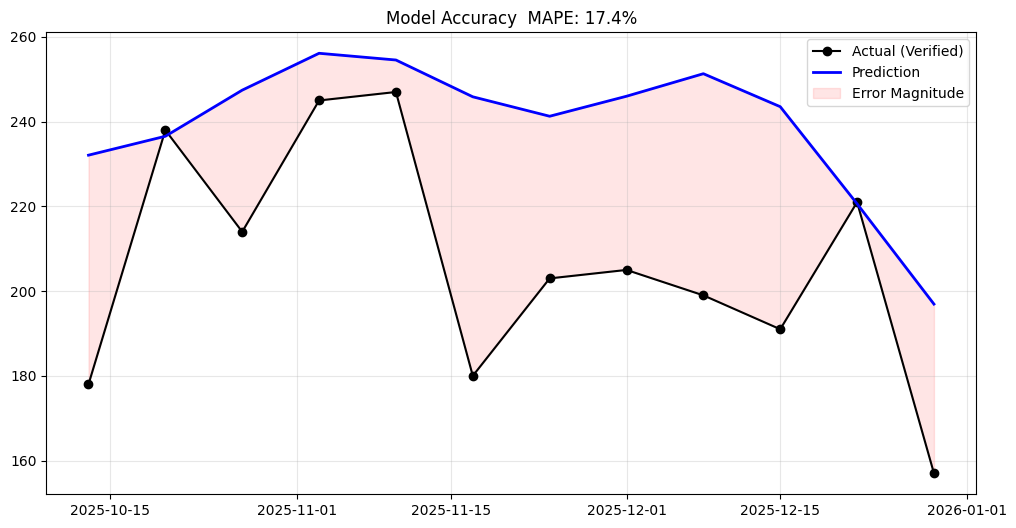

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(results_trimmed['ds'], results_trimmed['y'], 'ko-', label='Actual (Verified)', markersize=6)
plt.plot(results_trimmed['ds'], results_trimmed['yhat'], 'b-', label='Prediction', linewidth=2)
plt.fill_between(results_trimmed['ds'], results_trimmed['y'], results_trimmed['yhat'], 
                     color='red', alpha=0.1, label='Error Magnitude')
plt.title(f"Model Accuracy  MAPE: {mape_trimmed:.1f}%")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [28]:
print("\nWorst 3 Predictions (Where did we miss?):")
print(results_trimmed.sort_values('ape', ascending=False).head(3)[['ds', 'y', 'yhat', 'ape']])


Worst 3 Predictions (Where did we miss?):
           ds    y        yhat        ape
6  2025-11-17  180  245.864328  36.591293
1  2025-10-13  178  232.086414  30.385626
10 2025-12-15  191  243.530112  27.502676
